In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

In [1]:
df = pd.read_csv('data/as20000102.txt', sep='\s+', skiprows=[0,1,2])
df.columns = ['FromNodeId', 'ToNodeId', 'ExtraColumn']
df = df.drop(columns=['ExtraColumn'])
pd.set_option('display.max_rows', 100)
df


NameError: name 'pd' is not defined

In [4]:
import os
#data structures for our ndoes and edges
directory_path = 'data/as'
nodes = set()
edges = {}

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path) and filename.endswith('.txt'):
        #here, for formatting, it is easiest to skip the first four rows
        df = pd.read_csv(file_path, sep='\s+', skiprows=4, header=None, names=['FromNodeId', 'ToNodeId'])
        for index, row in df.iterrows():
            from_node, to_node = row['FromNodeId'], row['ToNodeId']
            nodes.add(from_node)
            nodes.add(to_node)
            edge = (from_node, to_node)
            if from_node != to_node: #don't include self-edges
                if edge in edges:
                    edges[edge] += 1
                else:
                    edges[edge] = 1



In [6]:

undirected_edges = {}
count =0

for (from_node, to_node), frequency in edges.items():
    reverse_edge = (to_node, from_node)
    if reverse_edge in edges:
        # Sort the nodes to maintain consistency (since (A, B) is the same as (B, A) in undirected graphs)
        undirected_edge = tuple(sorted([from_node, to_node]))
        
        # If this undirected edge has not been added yet, add it, else sum the frequencies
        if undirected_edge not in undirected_edges:
            undirected_edges[undirected_edge] = frequency + edges[reverse_edge]
    else:
        print(f"This node doesn't have a reverse{(from_node,to_node)}")
        count +=1



All undirected edges correctly sorted: True
Size of the directed edges dictionary: 42932
Minimum frequency value in directed edges: 1
count:0
Number of self-edges: 0


In [40]:
import networkx as nx
#initializing a networkx graph for computing the tie range
MultipleComponentGraph = nx.Graph()
for (node1, node2), frequency in undirected_edges.items():
    MultipleComponentGraph.add_edge(node1, node2, frequency=frequency) 

#Here it is important to check whether our graph is connected or split into multiple components 
 # as our tie_range function will return values of None if nodes are unreachable. 
 # If multiple components in our graph, we will create a new graph from the largest component 
# Luckily, the autonomous system network consists of only one component
print(f"Number of nodes in original: {MultipleComponentGraph.number_of_nodes()}")
GCC= sorted(nx.connected_components(MultipleComponentGraph), key=len, reverse=True)
print("How many components in graph", len(GCC))
LargestComponent=GCC[0]
OurGraph= MultipleComponentGraph.subgraph(LargestComponent)




Number of nodes in original: 7716
Number of edges: 21466
1
LargestComponent:7716


In [18]:
'''
Compute tie range using modified breadth-first search
Tie range does not consider tie weight
Input: Connected network component as a Networkx Graph object
Output: Tie range (second shortest path length)
'''

import networkx as nx


###Path search algorithm (alternating BFS from both source and target.)

def modified_bidirectional_pred_succ(G, source, target, cutoff):
    #This algorithm modifies https://networkx.lanl.gov/trac/browser/networkx/networkx/algorithms/shortest_paths/unweighted.py
    # Find second shortest path without deleting source-target tie.
    # BFS from both source and target and meets in the middle

    # handle either directed or undirected                                   
    if G.is_directed():
        Gpred = G.predecessors
        Gsucc = G.successors
    else:
        Gpred = G.neighbors
        Gsucc = G.neighbors

    # predecesssor and successors in search
    pred = {source: None}
    succ = {target: None}

    # initialize fringes, start with forward                                 
    forward_fringe = [source]
    reverse_fringe = [target]

    cummulative_depth = 0  #used to check the depth of the search.

    while forward_fringe and reverse_fringe:
        if cummulative_depth == 0:  #if cummulative_depth == 0, source's successors and target's predecessors at once. (2 waves in total)
            #Search source's successors
            cummulative_depth += 1  #Add one to cumulative depth for searching source's successors.
            this_level = forward_fringe
            forward_fringe = []
            for v in this_level:  #v is the source here.                                          
                for w in Gsucc(
                        v):  #for source's successors, w
                    if w not in pred and w != target:
                        forward_fringe.append(w)
                        pred[w] = v

            #Search target's predecessors
            cummulative_depth += 1  #Add one to cumulative depth for searching target's predecessors.
            this_level = reverse_fringe
            reverse_fringe = []
            for v in this_level:  #v is the target here.                                             
                for w in Gpred(v):  #w is the predecessor of the target.
                    if w not in succ and w != source:
                        succ[w] = v
                        reverse_fringe.append(w)

                    if w in pred and w != source:
                        return cummulative_depth

        else:
            cummulative_depth += 1  #After each round of search, add 1 to depth
            if len(forward_fringe) <= len(reverse_fringe):
                this_level = forward_fringe
                forward_fringe = []
                for v in this_level:
                    for w in Gsucc(v):
                        if w not in pred:
                            forward_fringe.append(w)
                            pred[w] = v
                        if w in succ:
                            #print "w", w
                            #print "forward_fringe:", forward_fringe
                            return cummulative_depth  # found path

            else:
                this_level = reverse_fringe
                reverse_fringe = []
                for v in this_level:
                    for w in Gpred(v):
                        if w not in succ:
                            succ[w] = v
                            reverse_fringe.append(w)
                        if w in pred:
                            #print "w", w
                            #print "reverse_fringe:", reverse_fringe
                            return cummulative_depth  # found path

            if cummulative_depth == cutoff:
                return 9999  #Any path that is greater than 10 will be coded as "9999". If the network splits into more than one component, it will return a value of "None".

def one_range(graph, edge, cutoff):
    #calculate path
    try:
        second_shortest_path_length = modified_bidirectional_pred_succ(G=graph, source=edge[0], target=edge[1], cutoff=cutoff)
        return second_shortest_path_length
    except:
        return None

def execute(graph, cutoff): #graph: NetworkX Graph() object, cutoff: maximum number of steps to search before terminating the tie range computation
    edge_iter = graph.edges()  #Iterate through all edges in the graph
    i = 0
    for v1, v2 in edge_iter:
        i += 1
        tie_range = one_range(graph, (v1, v2), cutoff)
        
        if int(v1) < int(v2):
            nodes_ordered = [v1, v2]
        else:
            nodes_ordered = [v2, v1]
        yield nodes_ordered, tie_range
            
        if i % 50000 == 0:
            print (i, "edges calculated.")

if __name__ == "__main__":
    cut_value = 21
    G = nx.Graph() # Construct the network from file
    range_iter = execute(graph=G, cutoff=cut_value)  #Ranges larger than cutoff are written as 9999.
    
        




In [19]:
for nodes_ordered, tie_range in execute(OurGraph, 100000):
    print("Nodes ordered:", nodes_ordered, "Tie range:", tie_range)


Nodes ordered: [1, 701] Tie range: 2
Nodes ordered: [1, 1740] Tie range: 2
Nodes ordered: [1, 2914] Tie range: 2
Nodes ordered: [1, 286] Tie range: 2
Nodes ordered: [1, 1673] Tie range: 2
Nodes ordered: [1, 7018] Tie range: 2
Nodes ordered: [1, 1800] Tie range: 2
Nodes ordered: [1, 293] Tie range: 2
Nodes ordered: [1, 1239] Tie range: 2
Nodes ordered: [1, 3561] Tie range: 2
Nodes ordered: [1, 568] Tie range: 2
Nodes ordered: [1, 2685] Tie range: 2
Nodes ordered: [1, 4200] Tie range: 2
Nodes ordered: [1, 6461] Tie range: 2
Nodes ordered: [1, 2548] Tie range: 2
Nodes ordered: [1, 6301] Tie range: 2
Nodes ordered: [1, 5696] Tie range: 2
Nodes ordered: [1, 11015] Tie range: 2
Nodes ordered: [1, 4000] Tie range: 2
Nodes ordered: [1, 71] Tie range: 2
Nodes ordered: [1, 33] Tie range: 2
Nodes ordered: [1, 714] Tie range: 2
Nodes ordered: [1, 3] Tie range: 2
Nodes ordered: [1, 3360] Tie range: 2
Nodes ordered: [1, 6172] Tie range: 2
Nodes ordered: [1, 6606] Tie range: 2
Nodes ordered: [1, 7725

In [23]:
#Now we want a new dictionary whose keys are undirected edges and values are tuple of frequency, tie range.
frequency_and_tie_range_dictionary={}
for edge in undirected_edges_corrected.keys():
    frequency = undirected_edges_corrected[edge]
    frequency_and_tie_range_dictionary[edge] = (frequency, -1)  


for nodes_ordered, tie_range in execute(OurGraph, 100000):
    
    edge = tuple(nodes_ordered)
    if edge in frequency_and_tie_range_dictionary and tie_range != None : #Can't visualize edges with None tie range
        frequency = frequency_and_tie_range_dictionary[edge][0]
        frequency_and_tie_range_dictionary[edge] = (frequency, tie_range)
        #at this point, any edges with tie range of -1 means they were unreachable.
frequency_and_tie_range_dictionary

{(1, 701): (1466, 2),
 (1, 1740): (1464, 2),
 (1, 2914): (1466, 2),
 (1, 286): (1454, 2),
 (1, 1673): (1448, 2),
 (1, 7018): (1116, 2),
 (1, 1800): (1196, 2),
 (1, 293): (1410, 2),
 (1, 1239): (1466, 2),
 (1, 3561): (1466, 2),
 (1, 568): (856, 2),
 (1, 2685): (1010, 2),
 (1, 4200): (1210, 2),
 (1, 6461): (910, 2),
 (1, 2548): (1024, 2),
 (1, 6301): (734, 2),
 (1, 5696): (922, 2),
 (1, 11015): (1184, 2),
 (1, 4000): (1160, 2),
 (1, 71): (1464, 2),
 (1, 33): (1464, 2),
 (1, 714): (1080, 2),
 (1, 3): (1464, 2),
 (1, 3360): (894, 2),
 (1, 6172): (890, 2),
 (1, 6606): (750, 2),
 (1, 7725): (1020, 2),
 (1, 7756): (1454, 2),
 (1, 5727): (1464, 2),
 (1, 6113): (986, 2),
 (1, 4565): (902, 2),
 (1, 6467): (910, 2),
 (1, 32): (1464, 2),
 (1, 174): (1296, 2),
 (1, 5646): (1014, 2),
 (1, 6453): (974, 2),
 (1, 8959): (834, 2),
 (1, 7176): (1464, 2),
 (1, 3549): (892, 2),
 (1, 1833): (956, 2),
 (1, 5683): (376, 2),
 (1, 3257): (982, 2),
 (1, 2856): (794, 2),
 (1, 8918): (848, 2),
 (1, 34): (1428, 2),

In [36]:
from collections import *
import random
#First, we ask how many nodes that had communicated are unreachable (tie range =-1)
#Second, let's randomly sample 30 of those nodes and check that by removing the edge 
# between them, it splits the graph into two components, which explains why our tie_range 
# is unreachable and that our tie_range function didn't make a mistake in calculating tie ranges.
print(Counter([x[1] for x in frequency_and_tie_range_dictionary.values()]))
negative_keys = [k for k, v in frequency_and_tie_range_dictionary.items() if v[1] == -1]
print((negative_keys))
for i in range(30):
  random_edge = random.choice(negative_keys)
  CopyGraph = OurGraph.copy()
  nodeu = random_edge[0]
  nodev = random_edge[1]
  CopyGraph.remove_edge(nodeu,nodev)
  number_of_connected=sorted(nx.connected_components(CopyGraph), key=len, reverse=True)
  print(len(number_of_connected))


Counter({2: 16133, 3: 3129, -1: 1923, 4: 256, 5: 21, 6: 4})
[(1, 199), (1, 5691), (1, 2581), (1, 281), (1, 10581), (1, 6150), (1, 1276), (1, 8078), (22, 5855), (22, 5881), (35, 5691), (45, 293), (99, 1760), (145, 10755), (149, 7170), (167, 3561), (172, 721), (174, 6654), (188, 293), (195, 1227), (204, 5050), (226, 4554), (227, 724), (239, 549), (255, 721), (286, 2819), (286, 6879), (292, 293), (293, 6406), (293, 3671), (293, 3431), (293, 3380), (295, 6350), (297, 1843), (297, 1254), (374, 7170), (380, 721), (385, 400), (390, 721), (395, 721), (398, 721), (412, 721), (424, 721), (440, 721), (467, 721), (497, 721), (511, 721), (513, 3350), (549, 802), (549, 808), (565, 1741), (577, 8187), (577, 831), (592, 7170), (637, 721), (638, 721), (686, 745), (700, 1740), (701, 10902), (701, 1744), (701, 2712), (701, 11355), (701, 6228), (701, 7029), (701, 2003), (701, 7762), (701, 7281), (701, 7256), (701, 7183), (701, 11520), (701, 7741), (701, 7317), (701, 7345), (701, 6589), (701, 3855), (701, 

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
from scipy import stats


tie_range_groups = {}
for (frequency, tie_range) in frequency_and_tie_range_dictionary.values():
    if tie_range != -1:
        if tie_range not in tie_range_groups:
            tie_range_groups[tie_range] = []
        tie_range_groups[tie_range].append(np.log(frequency)) #tie_range_groups' keys: tie range, values: list of logged frequencies
tie_ranges = []
mean_log_frequencies = []
confidence_intervals = []


for tie_range, log_freqs in tie_range_groups.items():
    tie_ranges.append(tie_range)
    mean_log_frequencies.append(np.mean(log_freqs))
    
    # Calculate the 99% confidence interval for log frequencies
    ci = stats.t.interval(0.99, len(log_freqs)-1, loc=np.mean(log_freqs), scale=stats.sem(log_freqs))
    confidence_intervals.append((ci[1] - ci[0]) / 2)  # Get the half width of the interval


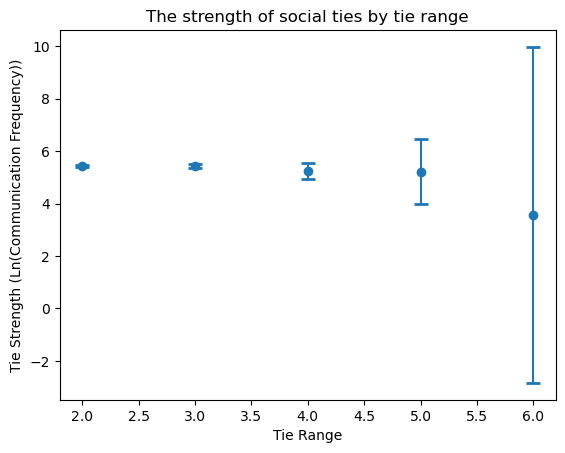

In [63]:
tie_ranges = np.array(tie_ranges)
mean_log_frequencies = np.array(mean_log_frequencies)
confidence_intervals = np.array(confidence_intervals)
plt.errorbar(tie_ranges, mean_log_frequencies, yerr=confidence_intervals, fmt='o', capsize=5, capthick=2)
plt.xlabel('Tie Range')
plt.ylabel('Tie Strength (Ln(Communication Frequency))')
plt.title('The strength of social ties by tie range')
plt.show()
